<h1 style="text-align:center">Simluation of a Simple, Planar Crane</h1>
<p style="text-align:center">Dr. Joshua Vaughan <br>
<a href="mailto:joshua.vaughan@louisiana.edu">joshua.vaughan@louisiana.edu</a><br>
http://www.ucs.louisiana.edu/~jev9637/   </p>

<p style="text-align:center">
    <img src="http://shared.crawlab.org/crane_positionInput.png" alt="The Simple, Planar Crane Model" width=35%/><br>
    <strong> Figure 1: The Simple, Planar Crane Model</strong>
</p>

This notebook simluates a the simple, planar crane model like the one shown in Figure 1. We'll be treating the trolley as the input to the pendulum system. This is fairily consistent with "real" cranes, where we can generally control the trolley location fairly well and are intersted in controlling the payload.

In this case, we can more explicitly draw the model like that in Figure 2. Because we're saying that we can exactly control $x(t)$, the mass of the trolley doesn't matter. We're really just controlling the pendulum connection point.

<p style="text-align:center">
    <img src="http://shared.crawlab.org/crane_positionInput_noTrolley.png" alt="The Simpler, Planar Crane Model" width=35%/><br>
    <strong> Figure 2: The "Trolley-input" Planar Crane Model</strong>
</p>


If we are treating the trolley as the input, the equation of motion for the payload angle is:

$ \quad \ddot{\theta} + \frac{g}{l}\theta = \frac{1}{l}\ddot{x} $

In order to simluate the system (in this case a single, second-order ODE), we need to write it as a system of first-order differential equations. To do so, let's define a state vector: 

$\quad \mathbf{w} = \left[w_1 \quad w_2\right]^T = \left[\theta \quad \dot{\theta}\right]^T $

We can then write the system in the form:

$ \quad \dot{\mathbf{w}} = f(\mathbf{w},\ddot{x},t) $

So,

$ \quad \dot{\mathbf{w}} = \left[w_2, \ -\frac{g}{l}w_1 + \frac{1}{l}\ddot{x}\right] $

We'll start by simluating the system using a nummerical differential equation solver, which could be used for more complex *and* nonlinear systems. We'll then see how to simluate the system using some functions from the [Python Control Systems Toolbox](https://www.cds.caltech.edu/~murray/wiki/Control_Systems_Library_for_Python).

## "Standard" Imports
First, we need to import [NumPy](http://www.numpy.org), the standard numerical *toolbox* we use, and [matplotlib](http://matplotlib.org), the standard plotting library. Nearly all of our projects will import NumPy, and those with plotting will always import matplotlib.

In [1]:
import numpy as np

In [2]:
# We want out plots to show up inline with the notebook
%matplotlib inline 

import matplotlib.pyplot as plt

## Simulation Using an ODE Solver

In [3]:
# We need to import the ode solver
from scipy.integrate import odeint

In [4]:
def eq_of_motion(w, t, p):
    """
    Defines the differential equations for the planar pendulum system.

    Arguments:
        w :  vector of the state variables:
        t :  time
        p :  vector of the parameters:
    """
    theta, theta_dot = w
    m, l, Distance, StartTime, Amax, Vmax, Shaper = p

    # Create sysODE = (theta', theta_dot')
    sysODE = [theta_dot,
             -g/l * theta + 1.0/l * x_ddot(t, p)]
    return sysODE


def x_ddot(t, p):
    """
    Defines the accel input to the system.
    
    We'll make a call to our lab function accel_input()
    
    Depending on the desired move distance, max accel, and max velocity, the input is either
    bang-bang or bang-coast-bang
    
    Arguments:
        t : current time step 
        p : vector of parameters
    """
    m, l, Distance, StartTime, Amax, Vmax, Shaper = p
    
    x_ddot = accel_input(Amax,Vmax,Distance,StartTime,t,Shaper)
    
    return x_ddot

In [5]:
# This cell includes functions to generate the acceleartion input

def accel_input(Amax,Vmax,Distance,StartTime,CurrTime,Shaper):
    """
    # Original MATLAB/Octave premable
    ###########################################################################
    # function [accel] = accel_input(Amax,Vmax,Distance,CurrTime,Shaper)
    #
    # Function returns acceleration at a given timestep based on user input
    #
    # Amax = maximum accel, assumed to besymmetric +/-
    # Vmax = maximum velocity, assumed to be symmetric in +/-
    # Distance = desired travel distance 
    # StartTime = Time command should begin
    # CurrTime = current time 
    # Shaper = array of the form [Ti Ai] - matches output format of shaper functions
    #           in toolbox
    #          * If Shaper is empty, then unshaped is run
    #
    #
    # Assumptions:
    #   * +/- maximums are of same amplitude
    #   * command will begin at StartTime (default = 0)
    #   * rest-to-rest bang-coast-bang move (before shaping)
    #
    # Created: 9/23/11 - Joshua Vaughan - vaughanje@gatech.edu
    #
    # Modified: 
    #   10/11/11
    #     * Added hard-coded shaping option - JEV (vaughanje@gatech.edu)
    #
    ###########################################################################
    #
    #
    # Converted to Python on 3/3/13 by Joshua Vaughan (joshua.vaughan@louisiana.edu)
    #
    # Modified:
    #   * 3/26/14 - Joshua Vaughan - joshua.vaughan@louisiana.edu
    #       - Updated some commenting, corrected typos
    #       - Updated numpy import as np
    """

    # These are the times for a bang-coast-bang input 
    t1 = StartTime
    t2 = (Vmax/Amax) + t1
    t3 = (Distance/Vmax) + t1
    t4 = (t2 + t3)-t1
    end_time = t4

    if len(Shaper) == 0:
        # If no shaper is input, create an unshaped command
        if t3 <= t2: # command should be bang-bang, not bang-coast-bang
            t2 = np.sqrt(Distance/Amax)+t1
            t3 = 2.0 * np.sqrt(Distance/Amax)+t1
            end_time = t3
        
            accel = Amax*(CurrTime > t1) - 2*Amax*(CurrTime > t2) + Amax*(CurrTime > t3)
    
        else: # command is bang-coast-bang
            accel = Amax*(CurrTime > t1) - Amax*(CurrTime > t2) - Amax*(CurrTime > t3) + Amax*(CurrTime > t4)

    else: # create a shaped command
        ts = np.zeros((9,1))
        A = np.zeros((9,1))
        # 	Parse Shaper parameters
        for ii in range(len(Shaper)):
            ts[ii] = Shaper[ii,0]  # Shaper impulse times
            A[ii] = Shaper[ii,1]  # Shaper impulse amplitudes

        # Hard-coded for now
        # TODO: be smarter about constructing the total input - JEV - 10/11/11
        accel = (A[0]*(Amax*(CurrTime > (t1+ts[0])) - Amax*(CurrTime > (t2+ts[0])) - Amax*(CurrTime > (t3+ts[0])) + Amax*(CurrTime > (t4+ts[0])))
        +	A[1]*(Amax*(CurrTime > (t1+ts[1])) - Amax*(CurrTime > (t2+ts[1])) - Amax*(CurrTime > (t3+ts[1])) + Amax*(CurrTime > (t4+ts[1])))
        +   A[2]*(Amax*(CurrTime > (t1+ts[2])) - Amax*(CurrTime > (t2+ts[2])) - Amax*(CurrTime > (t3+ts[2])) + Amax*(CurrTime > (t4+ts[2])))
        +   A[3]*(Amax*(CurrTime > (t1+ts[3])) - Amax*(CurrTime > (t2+ts[3])) - Amax*(CurrTime > (t3+ts[3])) + Amax*(CurrTime > (t4+ts[3])))
        +   A[4]*(Amax*(CurrTime > (t1+ts[4])) - Amax*(CurrTime > (t2+ts[4])) - Amax*(CurrTime > (t3+ts[4])) + Amax*(CurrTime > (t4+ts[4])))
        +   A[5]*(Amax*(CurrTime > (t1+ts[5])) - Amax*(CurrTime > (t2+ts[5])) - Amax*(CurrTime > (t3+ts[5])) + Amax*(CurrTime > (t4+ts[5])))
        +   A[6]*(Amax*(CurrTime > (t1+ts[6])) - Amax*(CurrTime > (t2+ts[6])) - Amax*(CurrTime > (t3+ts[6])) + Amax*(CurrTime > (t4+ts[6])))
        +   A[7]*(Amax*(CurrTime > (t1+ts[7])) - Amax*(CurrTime > (t2+ts[7])) - Amax*(CurrTime > (t3+ts[7])) + Amax*(CurrTime > (t4+ts[7])))
        +   A[8]*(Amax*(CurrTime > (t1+ts[8])) - Amax*(CurrTime > (t2+ts[8])) - Amax*(CurrTime > (t3+ts[8])) + Amax*(CurrTime > (t4+ts[8]))))

    return accel

In [6]:
# Define the parameters for simluation
g = 9.81                     # gravity (m/s^2)
l = 4.0                      # cable length (m)

wn = np.sqrt(g / l)            # natural frequency (rad/s)

# ODE solver parameters
abserr = 1.0e-9
relerr = 1.0e-9
max_step = 0.01
stoptime = 15.0
numpoints = 15001

# Create the time samples for the output of the ODE solver
t = np.linspace(0.,stoptime,numpoints)

# Initial conditions
theta_init = 0.0                        # initial position
theta_dot_init = 0.0                    # initial velocity

# Set up the parameters for the input function
Distance = 2.0              # Desired move distance (m)
Amax = 1.0                  # acceleration limit (m/s^2)
Vmax = 0.35                 # velocity limit (m/s)
StartTime = 0.5             # Time the y(t) input will begin

# Design and define an input Shaper  
Shaper = [] # An empty shaper means no input shaping

# Pack the parameters and initial conditions into arrays 
p = [g, l, Distance, StartTime, Amax, Vmax, Shaper]
x0 = [theta_init, theta_dot_init]

In [7]:
# Call the ODE solver.
response = odeint(eq_of_motion, x0, t, args=(p,), atol=abserr, rtol=relerr,  hmax=max_step)

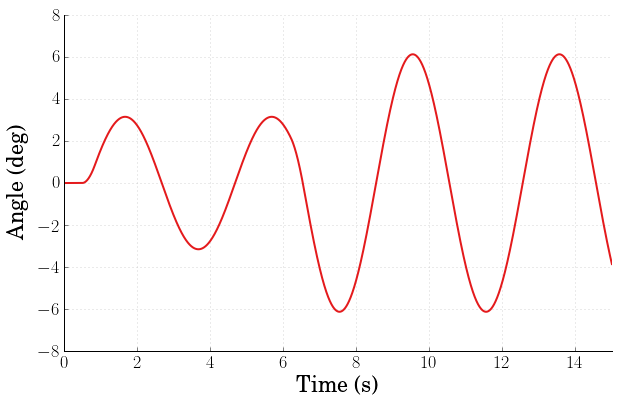

In [8]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)',family='serif',fontsize=22,weight='bold',labelpad=5)
plt.ylabel('Angle (deg)',family='serif',fontsize=22,weight='bold',labelpad=10)

plt.plot(t, response[:,0]*180/np.pi, linewidth=2, label=r'Angle')

# uncomment below and set limits if needed
plt.xlim(0,15)
# plt.ylim(0,10)

# Create the legend, then fix the fontsize
# leg = plt.legend(loc='upper right', fancybox=True)
# ltext  = leg.get_texts()
# plt.setp(ltext,family='serif',fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('Crane_AngleResponse.pdf')

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook

### What about Position?
We can also include the trolley location in the state vector. We know that how the position and velocity are related to the acceleration input. The new state vector becomes:


$\quad \mathbf{w} = \left[\theta \quad \dot{\theta} \quad x \quad \dot{x}\right]^T $

We can then write the system in the form:

$ \quad \dot{\mathbf{w}} = f(\mathbf{w},\ddot{x},t) $

So,

$ \quad \dot{\mathbf{w}} = \left[w_2 \quad -\frac{g}{l}w_1 + \frac{1}{l}\ddot{x} \quad w_3 \quad \ddot{x}\right] $

The acceleration, $\ddot{x}(t)$, is still the input to the system. The function from above can be used unaltered. It's recopied below to avoid confusion, but note that it is generally bad practice to have functions defined in muliple places in a script or notebook.

In [9]:
def eq_of_motion_withTrolley(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
        t :  time
        p :  vector of the parameters:
    """
    theta, theta_dot, x, x_dot = w
    m, l, Distance, StartTime, Amax, Vmax, Shaper = p

    # Create sysODE = (theta', theta_dot')
    sysODE = [theta_dot,
             -g/l * theta + 1.0/l * x_ddot(t, p),
             x_dot,
             x_ddot(t, p)]
    return sysODE

def x_ddot(t, p):
    """
    Defines the accel input to the system.
    
    We'll make a call to our lab function accel_input()
    
    Depending on the desired move distance, max accel, and max velocity, the input is either
    bang-bang or bang-coast-bang
    
    Arguments:
        t : current time step 
        p : vector of parameters
    """
    m, l, Distance, StartTime, Amax, Vmax, Shaper = p
    
    x_ddot = accel_input(Amax,Vmax,Distance,StartTime,t,Shaper)
    
    return x_ddot

We now need to specify the initial conditions for all the states, which include $x$ now. I've also respecified all the solver and system parameters for completeness. This is arguably bad practice, if the same parameters as above are being used. This also means that anytime I want to change a parameter, I would have to change it in mulitple places.

In [10]:
# Define the parameters for simluation
g = 9.81                     # gravity (m/s^2)
l = 4.0                      # cable length (m)

wn = np.sqrt(g / l)            # natural frequency (rad/s)

# ODE solver parameters
abserr = 1.0e-9
relerr = 1.0e-9
max_step = 0.01
stoptime = 15.0
numpoints = 15001

# Create the time samples for the output of the ODE solver
t = np.linspace(0.0, stoptime, numpoints)

# Initial conditions
theta_init = 0.0                        # initial angle (rad)
theta_dot_init = 0.0                    # initial angular velocity (rad/s)
x_init = 0.0                            # initial trolley position (m)
x_dot_init = 0.0                        # initial trolley velocity (m/s)

# Set up the parameters for the input function
Distance = 2.0              # Desired move distance (m)
Amax = 1.0                  # acceleration limit (m/s^2)
Vmax = 0.35                 # velocity limit (m/s)
StartTime = 0.5             # Time the y(t) input will begin

# Design and define an input Shaper  
Shaper = [] # An empty shaper means no input shaping

# Pack the parameters and initial conditions into arrays 
p = [g, l, Distance, StartTime, Amax, Vmax, Shaper]
x0 = [theta_init, theta_dot_init, x_init, x_dot_init]

In [11]:
# Call the ODE solver.
response_withTrolley = odeint(eq_of_motion_withTrolley, x0, t, args=(p,), atol=abserr, rtol=relerr,  hmax=max_step)

We can now parse the output of the ode solver (which now includes the trolley position) to plot the position of the trolley and payload. We know that the horizontal position of the payload is defined by:

$ \quad x_{paylaod} = x + l \sin{\theta} $

In [12]:
theta_resp = response_withTrolley[:,0]
theta_dot_resp = response_withTrolley[:,1]
x_resp = response_withTrolley[:,2]
x_dot_resp = response_withTrolley[:,3]

payload_position = x_resp + l * np.sin(theta_resp)

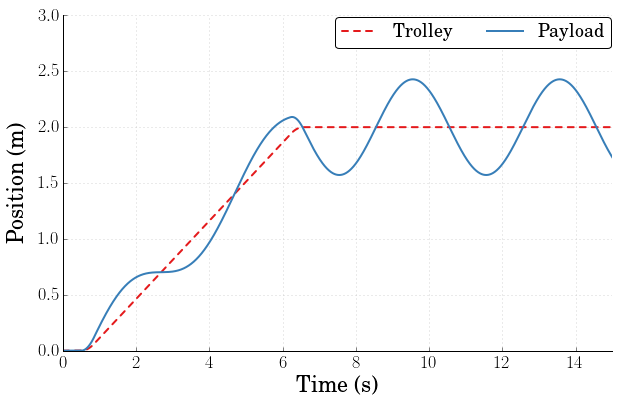

In [13]:
# Now, let's plot the horizontal position response

# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)',family='serif',fontsize=22,weight='bold',labelpad=5)
plt.ylabel('Position (m)',family='serif',fontsize=22,weight='bold',labelpad=10)

plt.plot(t, x_resp, linewidth=2, linestyle='--', label=r'Trolley')
plt.plot(t, payload_position, linewidth=2, linestyle='-', label=r'Payload')

# uncomment below and set limits if needed
plt.xlim(0,15)
plt.ylim(0,3)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol = 2, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('Crane_Position_Response.pdf')

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook

## Simluation Using the Control System Toolbox
<em>Coming soon...</em>

<hr class = "style-end">

#### Licenses
Code is licensed under a 3-clause BSD style license. See the licenses/LICENSE.md file.

Other content is provided under a [Creative Commons Attribution-NonCommercial 4.0 International License](http://creativecommons.org/licenses/by-nc/4.0/), CC-BY-NC 4.0.

In [14]:
# Ignore this cell - We just update the CSS to make the notebook look a little bit better and easier to read

# Improve the notebook styling -- Run this first
from IPython.core.display import HTML
css_file = '../styling/CRAWLAB_IPythonNotebook.css'
HTML(open(css_file, "r").read())